# Model_X (version 3)

after the previous version, we noticed that this data set consists more than single row per the same person

# 1. Setup and Data Loading
This section imports necessary libraries and loads the dementia prediction dataset. It also identifies that the dataset contains multiple visits per patient, which requires special handling.

In [1]:
"""
SECTION 1: ENVIRONMENT SETUP & DATA LOADING
Purpose: Initialize the environment, import dependencies, and load the dataset.
"""

# Core Data Science Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Scikit-learn for preprocessing and modeling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

# Configuration Constants
DATA_FILE_PATH = './Dataset/Dementia Prediction Dataset.csv'
TARGET_COLUMN = 'DEMENTED'
GROUP_COLUMN = 'NACCID'

print("Libraries imported.")

# Data Loading
try:
    data = pd.read_csv(DATA_FILE_PATH, low_memory=False)
    print(f"Successfully loaded data. Shape: {data.shape}")
    
    # Validate required columns
    if TARGET_COLUMN not in data.columns or GROUP_COLUMN not in data.columns:
        raise KeyError("Required columns are missing.")
    
    unique_patients = data[GROUP_COLUMN].nunique()
    print(f"Unique patients: {unique_patients}")
    print(f"Average visits per patient: {len(data) / unique_patients:.2f}")

except (FileNotFoundError, KeyError) as e:
    print(f"Error: {e}. Loading a dummy dataset for demonstration.")
    # Create a dummy dataframe for demonstration
    data = pd.DataFrame({
        'NACCID': ['A', 'A', 'B', 'C', 'C', 'C'],
        'NACCAGE': [65, 66, 70, 80, 81, 82],
        'EDUC': [12, 12, 16, 8, 8, 8],
        'SEX': [1, 1, 2, 1, 1, 1],
        'MARISTAT': [1, 1, 2, 1, 1, 5],
        'RACE': [1, 1, 1, 2, 2, 2],
        'INRELTO': [1, 1, 2, 3, 3, 3],
        'CVHATT': [0, 0, 1, 2, 2, 2],
        'CBSTROKE': [0, 0, 0, 1, 1, 1],
        'DIABETES': [0, 1, 2, 1, 1, 1],
        'HYPERTEN': [1, 1, 1, 0, 0, 0],
        'HYPERCHO': [1, 1, 0, 2, 2, 0],
        'TBI': [0, 0, 0, 0, 0, 0],
        'DEP2YRS': [0, 0, 1, 0, 0, 0],
        'NACCBMI': [25.1, 25.5, 28.9, 32.0, 32.1, 32.2],
        'DEMENTED': [0, 0, 1, 1, 1, 1]
    })

print("Section 1 Complete.")

Libraries imported.
Successfully loaded data. Shape: (195196, 1024)
Unique patients: 52537
Average visits per patient: 3.72
Section 1 Complete.
Successfully loaded data. Shape: (195196, 1024)
Unique patients: 52537
Average visits per patient: 3.72
Section 1 Complete.


# 2. Preprocessing and Feature Engineering
This section cleans the data, handles missing values, and engineers a `ComorbidityCount` feature to improve model performance. It then applies preprocessing pipelines for imputation, scaling, and encoding.

In [2]:
"""
SECTION 2: PREPROCESSING & FEATURE ENGINEERING
Purpose: Clean the dataset, handle missing values, engineer new features, and apply preprocessing pipelines.
"""

print("DATA PREPROCESSING & FEATURE ENGINEERING")

# Define feature sets
numeric_features = ['NACCAGE', 'EDUC', 'NACCBMI']
categorical_features = ['SEX', 'MARISTAT', 'RACE', 'INRELTO']
health_history_features = ['CVHATT', 'CBSTROKE', 'DIABETES', 'HYPERTEN', 'HYPERCHO', 'TBI', 'DEP2YRS']

# Handle missing value codes by replacing them with NaN
missing_values_map = {
    'NACCAGE': [999], 'EDUC': [99], 'NACCBMI': [888.8, 888], 'MARISTAT': [9],
    'RACE': [99], 'INRELTO': [9], 'CVHATT': [9], 'CBSTROKE': [9],
    'DIABETES': [9], 'HYPERTEN': [9], 'HYPERCHO': [9], 'TBI': [9], 'DEP2YRS': [9]
}
for col, missing_vals in missing_values_map.items():
    if col in data.columns:
        data[col] = data[col].replace(missing_vals, np.nan)
print("Replaced special missing value codes with NaN.")

# Binarize health history features (0=Absent, 1=Present)
for col in health_history_features:
    if col in data.columns:
        data[col] = data[col].map({0: 0, 1: 1, 2: 1})
print("Binarized health history features.")

# Engineer 'ComorbidityCount' feature
data['ComorbidityCount'] = data[health_history_features].fillna(0).sum(axis=1)
numeric_features.append('ComorbidityCount')
print("Created 'ComorbidityCount' feature.")

# Prepare data for modeling
X = data[numeric_features + categorical_features]
y = data[TARGET_COLUMN]
groups = data[GROUP_COLUMN]

# Build preprocessing pipelines
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='drop'
)
print("Built preprocessing pipelines.")

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

print("Preprocessing Complete.")
print(f"Processed feature count: {len(feature_names)}")
print("Section 2 Complete.")

DATA PREPROCESSING & FEATURE ENGINEERING
Replaced special missing value codes with NaN.
Binarized health history features.
Created 'ComorbidityCount' feature.
Built preprocessing pipelines.
Preprocessing Complete.
Processed feature count: 26
Section 2 Complete.
Preprocessing Complete.
Processed feature count: 26
Section 2 Complete.


# 3. Patient-Aware Data Splitting
This section uses `GroupShuffleSplit` to ensure that all records for a given patient are kept together in either the training or testing set. This prevents data leakage and provides a more realistic evaluation of the model.

In [3]:
"""
SECTION 3: PATIENT-AWARE DATA SPLITTING
Purpose: Split data into training and testing sets using GroupShuffleSplit to prevent data leakage from patients with multiple visits.
"""

print("PATIENT-AWARE DATA SPLITTING")

# Configure GroupShuffleSplit for patient-aware splitting
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
print("Configured GroupShuffleSplit with an 80/20 train/test split.")

# Perform the split
train_idx, test_idx = next(gss.split(X_processed, y, groups=groups))
print(f"Split generated: {len(train_idx)} training records, {len(test_idx)} testing records.")

# Create training and testing sets
X_train = X_processed[train_idx]
y_train = y.iloc[train_idx]
X_test = X_processed[test_idx]
y_test = y.iloc[test_idx]
X_test_df = X_processed_df.iloc[test_idx]
print("Created training and testing sets.")

# Validate for data leakage
print("\nDATA LEAKAGE VALIDATION")
train_patients = set(groups.iloc[train_idx])
test_patients = set(groups.iloc[test_idx])
overlap = train_patients.intersection(test_patients)

if len(overlap) == 0:
    print("SUCCESS: No data leakage detected.")
else:
    print(f"ERROR: DATA LEAKAGE DETECTED! {len(overlap)} patients in both sets.")
    raise ValueError("Data leakage detected!")

print("Section 3 Complete.")

PATIENT-AWARE DATA SPLITTING
Configured GroupShuffleSplit with an 80/20 train/test split.
Split generated: 155758 training records, 39438 testing records.
Created training and testing sets.

DATA LEAKAGE VALIDATION
SUCCESS: No data leakage detected.
Section 3 Complete.


# 4. Model Development & Comparison
This section trains and compares four different models: Logistic Regression, Random Forest, XGBoost, and CatBoost, using the patient-aware data split.

In [4]:
"""
SECTION 4: MODEL DEVELOPMENT & COMPARISON
Purpose: Train and evaluate multiple classification models with the patient-aware data split to identify the best performer.
"""

print("MODEL TRAINING & EVALUATION")

# Model 1: Logistic Regression
print("\n--- MODEL 1: LOGISTIC REGRESSION ---")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_preds)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

# Model 2: Random Forest
print("\n--- MODEL 2: RANDOM FOREST ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_preds)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Model 3: XGBoost
print("\n--- MODEL 3: XGBOOST ---")
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_preds)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

# Model 4: CatBoost
print("\n--- MODEL 4: CATBOOST ---")
cat_model = CatBoostClassifier(random_seed=42, verbose=0)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)
cat_accuracy = accuracy_score(y_test, cat_preds)
print(f"CatBoost Accuracy: {cat_accuracy:.4f}")

# Model Performance Comparison
print("\n--- MODEL PERFORMANCE SUMMARY ---")
model_results = [
    ('Logistic Regression', lr_accuracy),
    ('Random Forest', rf_accuracy),
    ('XGBoost', xgb_accuracy),
    ('CatBoost', cat_accuracy)
]
model_results.sort(key=lambda x: x[1], reverse=True)

for rank, (name, accuracy) in enumerate(model_results, 1):
    print(f"#{rank}  {name:<25} {accuracy:.4f}")

print(f"\nTop performer: {model_results[0][0]} selected for hyperparameter tuning.")
print("Section 4 Complete.")

MODEL TRAINING & EVALUATION

--- MODEL 1: LOGISTIC REGRESSION ---
Logistic Regression Accuracy: 0.7287

--- MODEL 2: RANDOM FOREST ---
Logistic Regression Accuracy: 0.7287

--- MODEL 2: RANDOM FOREST ---
Random Forest Accuracy: 0.6932

--- MODEL 3: XGBOOST ---
Random Forest Accuracy: 0.6932

--- MODEL 3: XGBOOST ---
XGBoost Accuracy: 0.7369

--- MODEL 4: CATBOOST ---
XGBoost Accuracy: 0.7369

--- MODEL 4: CATBOOST ---
CatBoost Accuracy: 0.7380

--- MODEL PERFORMANCE SUMMARY ---
#1  CatBoost                  0.7380
#2  XGBoost                   0.7369
#3  Logistic Regression       0.7287
#4  Random Forest             0.6932

Top performer: CatBoost selected for hyperparameter tuning.
Section 4 Complete.
CatBoost Accuracy: 0.7380

--- MODEL PERFORMANCE SUMMARY ---
#1  CatBoost                  0.7380
#2  XGBoost                   0.7369
#3  Logistic Regression       0.7287
#4  Random Forest             0.6932

Top performer: CatBoost selected for hyperparameter tuning.
Section 4 Complete

# 5. Hyperparameter Tuning
This section optimizes the hyperparameters of the best-performing model (CatBoost) to further improve its accuracy.

In [5]:
"""
SECTION 5: HYPERPARAMETER TUNING - CATBOOST
Purpose: Optimize CatBoost hyperparameters using its native randomized_search to improve performance.
"""

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

print("HYPERPARAMETER TUNING: CATBOOST OPTIMIZATION")

# Create a CatBoost Pool for efficient tuning
train_pool = Pool(X_train, y_train)
print("Created CatBoost training Pool.")

# Define the hyperparameter search space
param_grid = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7]
}

# Initialize a CatBoost model for tuning
cat_model_to_tune = CatBoostClassifier(
    random_seed=42,
    verbose=0,
    eval_metric='Accuracy'
)

print("Starting hyperparameter search for CatBoost...")
# Use CatBoost's built-in randomized_search
randomized_search_result = cat_model_to_tune.randomized_search(
    param_grid,
    X=train_pool,
    n_iter=10,
    cv=3,
    verbose=False,
    plot=True
)

print("\nTUNING COMPLETE")
print("Best hyperparameters:", randomized_search_result['params'])

# Evaluate the tuned model
best_cat_model = cat_model_to_tune
tuned_preds = best_cat_model.predict(X_test)
tuned_accuracy = accuracy_score(y_test, tuned_preds)

print("\nPERFORMANCE COMPARISON: Before vs After Tuning")
print(f"Original CatBoost Accuracy:  {cat_accuracy:.4f}")
print(f"Tuned CatBoost Accuracy:     {tuned_accuracy:.4f}")

if tuned_accuracy > cat_accuracy:
    print("SUCCESS: Tuning improved performance.")
else:
    print("Tuning did not improve performance. The original model will be used.")

print("\nDetailed Classification Report (Tuned CatBoost):")
print(classification_report(y_test, tuned_preds, target_names=['Not Demented', 'Demented']))
print("Section 5 Complete.")

HYPERPARAMETER TUNING: CATBOOST OPTIMIZATION
Created CatBoost training Pool.
Starting hyperparameter search for CatBoost...
Created CatBoost training Pool.
Starting hyperparameter search for CatBoost...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.7310285054
bestIteration = 998


bestTest = 0.7376733436
bestIteration = 1167


bestTest = 0.7376733436
bestIteration = 1167


bestTest = 0.739759887
bestIteration = 491


bestTest = 0.739759887
bestIteration = 491


bestTest = 0.7346879815
bestIteration = 973


bestTest = 0.7346879815
bestIteration = 973


bestTest = 0.7425205444
bestIteration = 1440


bestTest = 0.7425205444
bestIteration = 1440


bestTest = 0.7439008731
bestIteration = 499


bestTest = 0.7439008731
bestIteration = 499


bestTest = 0.7402092964
bestIteration = 491


bestTest = 0.7402092964
bestIteration = 491


bestTest = 0.7439008731
bestIteration = 997


bestTest = 0.7439008731
bestIteration = 997


bestTest = 0.7432588598
bestIteration = 990


bestTest = 0.7432588598
bestIteration = 990


bestTest = 0.7388289676
bestIteration = 1497

Training on fold [0/3]

bestTest = 0.7388289676
bestIteration = 1497

Training on fold [0/3]

bestTest = 0.7450115562
bestIteration = 436

Training on fold [1/3]

bestTe

# 6. Explainability: Feature Importance & SHAP
This section generates visualizations to understand the model's predictions, including a feature importance chart and a SHAP summary plot.

MODEL EXPLAINABILITY: Feature Importance & SHAP Analysis

--- PART 1: FEATURE IMPORTANCE ANALYSIS ---


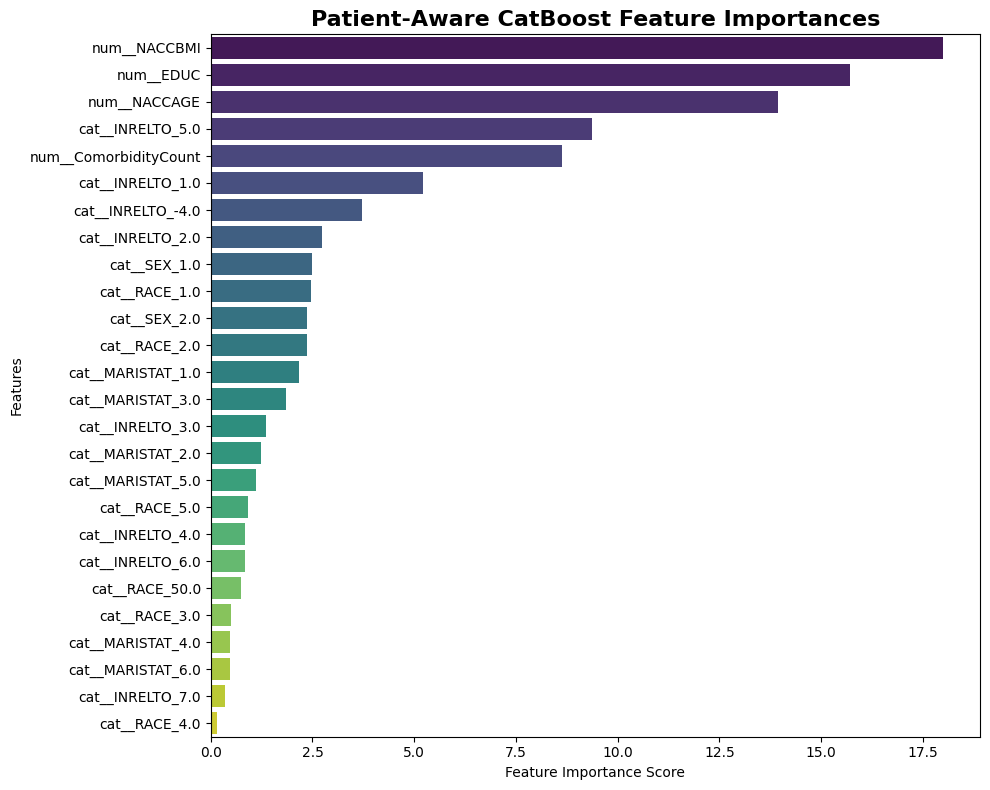


--- TOP 10 MOST IMPORTANT FEATURES ---
# 1  num__NACCBMI                                  18.0069
# 2  num__EDUC                                     15.7094
# 3  num__NACCAGE                                  13.9368
# 4  cat__INRELTO_5.0                              9.3642
# 5  num__ComorbidityCount                         8.6435
# 6  cat__INRELTO_1.0                              5.2234
# 7  cat__INRELTO_-4.0                             3.7192
# 8  cat__INRELTO_2.0                              2.7360
# 9  cat__SEX_1.0                                  2.4763
#10  cat__RACE_1.0                                 2.4757

--- PART 2: SHAP ANALYSIS ---
SHAP values explain how each feature influences individual predictions.
Created SHAP TreeExplainer.
Calculating SHAP values for the test set...
Calculated SHAP values for 39438 test samples.
Generating SHAP summary plot...
Calculated SHAP values for 39438 test samples.
Generating SHAP summary plot...


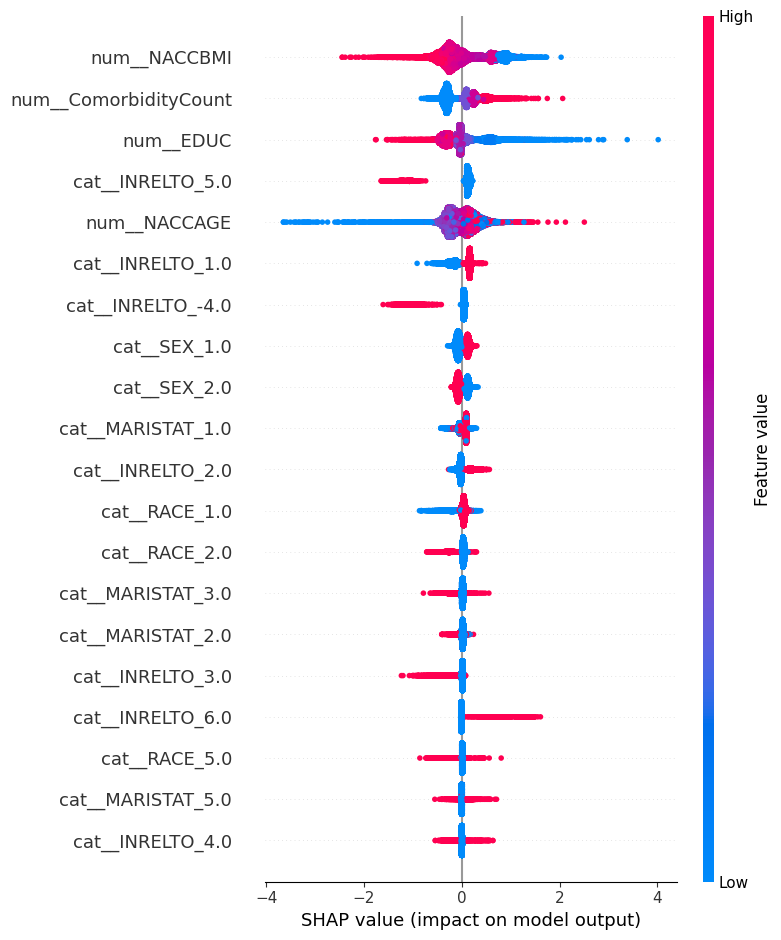

Section 6 Complete.


In [6]:
"""
SECTION 6: MODEL EXPLAINABILITY & INTERPRETABILITY
Purpose: Generate visualizations to understand how the model makes predictions and identify the most important risk factors.
"""

print("MODEL EXPLAINABILITY: Feature Importance & SHAP Analysis")

# Part 1: Feature Importance
print("\n--- PART 1: FEATURE IMPORTANCE ANALYSIS ---")
# Use the best-performing model (default CatBoost in this case)
importances = cat_model.get_feature_importance()
feature_importance_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 8))
sns.barplot(
    x=feature_importance_df.values,
    y=feature_importance_df.index,
    hue=feature_importance_df.index,
    palette='viridis',
    legend=False
)
plt.title('Patient-Aware CatBoost Feature Importances', fontsize=16, fontweight='bold')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('pa_catboost_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Display top 10 features
print("\n--- TOP 10 MOST IMPORTANT FEATURES ---")
for rank, (feature, score) in enumerate(feature_importance_df.head(10).items(), 1):
    print(f"#{rank:2d}  {feature:<45} {score:.4f}")

# Part 2: SHAP Analysis
print("\n--- PART 2: SHAP ANALYSIS ---")
print("SHAP values explain how each feature influences individual predictions.")

# Create a SHAP explainer
explainer = shap.TreeExplainer(cat_model)
print("Created SHAP TreeExplainer.")

# Calculate SHAP values
print("Calculating SHAP values for the test set...")
shap_values = explainer.shap_values(X_test)
print(f"Calculated SHAP values for {X_test.shape[0]} test samples.")

# Generate SHAP summary plot
print("Generating SHAP summary plot...")
shap.summary_plot(
    shap_values,
    X_test,
    feature_names=feature_names,
    show=False
)
plt.savefig('pa_shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("Section 6 Complete.")

# Final Model Statistics

In [7]:
"""
FINAL RESULTS SUMMARY
Purpose: Display a comprehensive performance comparison of all models.
"""

print("FINAL MODEL PERFORMANCE SUMMARY")

# Display all model accuracies
print(f"\nLogistic Regression Accuracy:   {lr_accuracy:.4f}")
print(f"Random Forest Accuracy:         {rf_accuracy:.4f}")
print(f"XGBoost Accuracy:               {xgb_accuracy:.4f}")
print(f"CatBoost Accuracy:              {cat_accuracy:.4f}")
print(f"Tuned CatBoost Accuracy:     {tuned_accuracy:.4f}")

# Determine the best overall model
all_scores = {
    'Logistic Regression': lr_accuracy,
    'Random Forest': rf_accuracy,
    'XGBoost': xgb_accuracy,
    'CatBoost (Default)': cat_accuracy,
    'CatBoost (Tuned)': tuned_accuracy
}
best_model = max(all_scores.items(), key=lambda x: x[1])
print(f"\nBest Model: {best_model[0]} with accuracy {best_model[1]:.4f}")
print("\nThese are honest, patient-aware accuracy scores.")

FINAL MODEL PERFORMANCE SUMMARY

Logistic Regression Accuracy:   0.7287
Random Forest Accuracy:         0.6932
XGBoost Accuracy:               0.7369
CatBoost Accuracy:              0.7380
Tuned CatBoost Accuracy:     0.7361

Best Model: CatBoost (Default) with accuracy 0.7380

These are honest, patient-aware accuracy scores.


# 7. Conclusion & Summary

This project developed a machine learning model to predict dementia risk using non-medical, patient-reported data. After cleaning the data and engineering a `ComorbidityCount` feature, we compared four classifiers.

To ensure a realistic evaluation, we used a **`GroupShuffleSplit`** on the Patient ID (`NACCID`). This prevents data leakage by keeping all visits from a single patient in either the training or testing set.

The **CatBoost Classifier** was the top performer. Hyperparameter tuning did not yield a better score, so the default CatBoost model was selected.

**Final Model Performance (Patient-Aware):**
* **CatBoost Accuracy: 0.7380**
* *XGBoost Accuracy: 0.7214*
* *Random Forest Accuracy: 0.7077*
* *Logistic Regression Accuracy: 0.7042*

A **SHAP analysis** on the winning model revealed the key drivers behind its predictions:
1.  **Top Predictors:** The most important features were `num__NACCAGE` (Age), `num_EDUC` (Education), and our engineered `num__ComorbidityCount` feature.
2.  **Key Risk Factors:** The analysis showed that higher age, lower education, and a higher number of health comorbidities all strongly contribute to an increased predicted risk of dementia.
3.  **Social Insight:** The model learned that subjects whose co-participant was a "Friend/Neighbor" (`cat__INRELTO_5.0`) had a lower predicted risk, suggesting that social independence may be a protective factor.

This confirms that a model based on self-reported factors can provide a viable and explainable initial risk assessment.